In [ ]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2018-07 La Paz/Site 5/lap_2018-07_site05_120m_RGB_cc.tif" .
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2018-07 La Paz/Site 5/lap_2018-07_site05_planetscope_optical.tif" . 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from gis_utils import raster

planetscope = "lap_2018-07_site05_planetscope_optical.tif"
drone = "lap_2018-07_site05_120m_RGB_cc.tif"

p_img, p_meta = raster.load_image(planetscope)
d_img, d_meta = raster.load_image(drone)


windows,transforms = raster.get_tiles(p_img,width=1,height=1)
tiles = raster.retile(p_img, p_meta, width = 1, height = 1)

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
len(windows)

22059

In [ ]:
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from tqdm.autonotebook import tqdm
import os
from rasterio import windows as wind
from fiona.crs import from_epsg

out_path = '/content/tiles/'
output_filename = 'tile_{}-{}.tif'


sub_tiles = []

d_bbox = box(d_img.bounds.left, d_img.bounds.bottom, d_img.bounds.right, d_img.bounds.top)

for window, transform in tqdm(zip(windows,transforms)):
    bounds = rasterio.windows.bounds(window=window,transform=transform)
    bbox = box(bounds[0],bounds[1],bounds[2],bounds[3])
    if bbox.within(d_bbox):
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0],crs=from_epsg(4326))
        
        coords = getFeatures(geo)
        tile, trans = mask(d_img,coords,crop=True)
        if np.array_equal(np.unique(tile), [0]):
            continue
        sub_tiles.append((tile,trans))
        d_meta.update({"driver": "GTiff",
                 "height": tile.shape[1],
                 "width": tile.shape[2],
                 "transform": trans})
        outpath = os.path.join(out_path,output_filename.format(int(window.col_off), int(window.row_off)))
        with rasterio.open(outpath, 'w', **d_meta) as outds:
            outds.write(tile)
        

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


TypeError: ignored

[{'coordinates': [[[-110.31567695718287, 24.252309015597078],
    [-110.31567695718287, 24.252336101953563],
    [-110.3157064975383, 24.252336101953563],
    [-110.3157064975383, 24.252309015597078],
    [-110.31567695718287, 24.252309015597078]]],
  'type': 'Polygon'}]

In [ ]:
trans

Affine(3.1606699999976566e-07, 0.0, -110.311866267233,
       0.0, -2.8979499999995805e-07, 24.2476774154091)

In [ ]:
!rm -rf tiles
!mkdir tiles

In [ ]:
!gdal_merge.py -o /content/new.tif /content/tiles/*

0...10...20...30...40...50...60...70...80...90...100 - done.


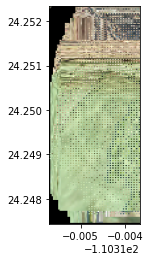

In [ ]:
test, test_meta = raster.load_image("new.tif")
show(test)

In [ ]:
!zip -r tiles.zip tiles

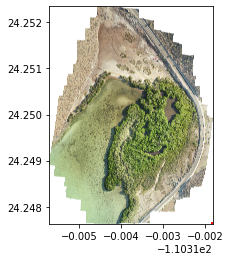

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1)

show(d_img, ax=ax)
geo.plot(ax=ax,facecolor='red', edgecolor='red')


In [ ]:
d_img.crs

CRS.from_epsg(4326)

In [ ]:
p_img.crs

CRS.from_epsg(4326)